In [292]:
import numpy as np
import math
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [293]:
#tanh = (e^2x - 1)/(e^2x + 1)

x = np.array([[0.5, -0.2]])

y = np.array([1])

w1 = np.array([[0.3, -0.1], 
                [0.2, 0.4]])

b1 = np.array([[0.1], [-0.2]])

w2 = np.array([[0.5, -0.3]])

b2 = np.array([[0.2]])

learning_rate = 0.3


# Forward Pass

In [294]:
z = w1 @ x.T + b1

z

array([[ 0.27],
       [-0.18]])

In [295]:
h = np.tanh(z)

h

array([[ 0.26362484],
       [-0.17808087]])

In [296]:
u = w2 @ h + b2

u

array([[0.38523668]])

In [297]:
y_pred = np.tanh(u)

y_pred

array([[0.36724656]])

# Loss Calculation

In [298]:
mse = 1/2 * (y - y_pred)**2

mse

array([[0.20018846]])

# Backward Pass

In [299]:
gradient = -1 * (y-y_pred) * (1-y_pred**2)
gradient

array([[-0.54741396]])

In [300]:
hidden_grad = (w2.T @ gradient) * (1 - h**2)
hidden_grad

array([[-0.25468488],
       [ 0.15901618]])

In [301]:
w_grad = hidden_grad @ x
w_grad

array([[-0.12734244,  0.05093698],
       [ 0.07950809, -0.03180324]])

In [302]:
w2_grad = gradient @ h.T
b1_grad = hidden_grad
b2_grad = gradient

In [303]:
w2_grad, b2_grad, b1_grad

(array([[-0.14431191,  0.09748395]]),
 array([[-0.54741396]]),
 array([[-0.25468488],
        [ 0.15901618]]))

In [304]:
learning_rate = 0.1

In [305]:
w1 -= learning_rate * w_grad
b1 -= learning_rate * b1_grad
w2 -= learning_rate * w2_grad
b2 -= learning_rate * b2_grad

In [306]:
w1, b1, w2, b2

(array([[ 0.31273424, -0.1050937 ],
        [ 0.19204919,  0.40318032]]),
 array([[ 0.12546849],
        [-0.21590162]]),
 array([[ 0.51443119, -0.3097484 ]]),
 array([[0.2547414]]))

# Binary Classification with Synthetic Data and Scratch MLP

In [307]:
def create_data(samples, classes, clusters, features, informative, redundant, random_state):
    X, y = make_classification(n_samples=samples, n_classes=classes, n_clusters_per_class=clusters, 
                               n_features=features, n_informative=informative, n_redundant=redundant, 
                               random_state=random_state, class_sep=1.2, flip_y=0.05)
    
    return X,y

In [308]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [309]:
def forward(X, weight, bias):
    z = X @ weight + bias
    return sigmoid(z), z

In [310]:
def binary_cross_entropy(y_true, y_pred):
    m = len(y_true)
    eps = 1e-8
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

In [311]:
def backward_pass(X, y, cache, W1, W2, loss_type='bce'):
    m = X.shape[0]

    A1, A2 = cache["A1"], cache["A2"]

    if loss_type == 'bce':
        y = y.reshape(-1, 1)

    dZ2 = A2 - y
    dW2 = (A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (A1 * (1 - A1))
    dW1 = (X.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

In [312]:
def softmax(z):
    exp = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def categorical_cross_entropy(y_true, y_pred):
    eps = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

def one_hot(y, num_classes):
    oh = np.zeros((len(y), num_classes))
    oh[np.arange(len(y)), y] = 1
    return oh

In [313]:
def mlp(X,y,epochs, neurons_per_layer, lr=0.1, loss_type='bce'):
    n_input, n_hidden, n_output = neurons_per_layer
    
    W1 = np.random.randn(n_input, n_hidden) * 0.01
    b1 = np.zeros((1, n_hidden))
    W2 = np.random.randn(n_hidden, n_output) * 0.01
    b2 = np.zeros((1, n_output))

    losses = []

    for epoch in range(epochs):
        A1, Z1 = forward(X, W1, b1)
        A2, Z2 = forward(A1, W2, b2)

        if loss_type == 'bce':
            loss = binary_cross_entropy(y.reshape(-1,1), A2)
            losses.append(loss)
        elif loss_type == 'cce':
            loss = categorical_cross_entropy(y, A2)
            losses.append(loss)

        cache = {"A1": A1, "A2": A2}
        grads = backward_pass(X, y, cache, W1, W2, loss_type)

        W1 -= lr * grads["dW1"]
        b1 -= lr * grads["db1"]
        W2 -= lr * grads["dW2"]
        b2 -= lr * grads["db2"]

        if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return W1, b1, W2, b2, losses

In [314]:
def predict(X, W1, b1, W2, b2, loss_type='bce'):
    A1 = sigmoid(X @ W1 + b1)
    if loss_type == 'cce':
        A2 = softmax(A1 @ W2 + b2)
        return np.argmax(A2, axis=1)
    A2 = sigmoid(A1 @ W2 + b2)
    return (A2 > 0.5).astype(int).flatten()

# Exercicio 2

Epoch 0, Loss: 0.6932
Epoch 50, Loss: 0.6931
Epoch 100, Loss: 0.6930
Epoch 150, Loss: 0.6930
Epoch 200, Loss: 0.6928
Epoch 250, Loss: 0.6926
Epoch 300, Loss: 0.6921
Epoch 350, Loss: 0.6912
Epoch 400, Loss: 0.6894
Epoch 450, Loss: 0.6862
Test Accuracy: 0.67


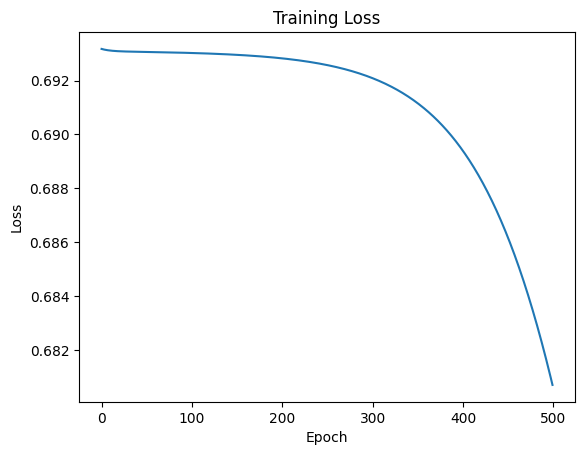

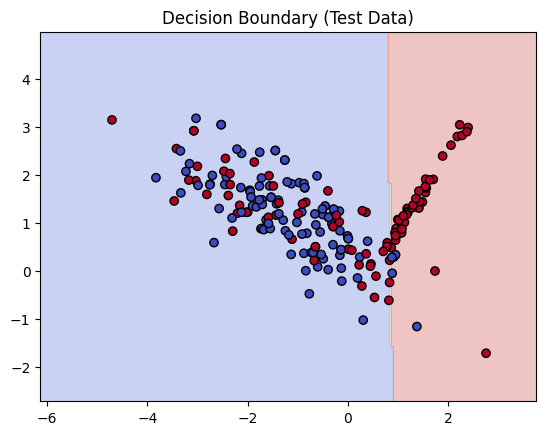

In [315]:
X0, y0 = create_data(
        samples=500, classes=1, clusters=1,
        features=2, informative=2, redundant=0,
        random_state=42
    )
y0 = np.zeros(len(y0))

X1, y1 = create_data(
    samples=500, classes=1, clusters=2,
    features=2, informative=2, redundant=0,
    random_state=42
)

y1 = np.ones(len(y1))

X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

W1, b1, W2, b2, losses = mlp(X_train, y_train,
                             epochs=500,
                             neurons_per_layer=[2, 4, 1],
                             lr=0.1,
                             loss_type='bce')

y_pred = predict(X_test, W1, b1, W2, b2, loss_type='bce')
acc = np.mean(y_pred == y_test)
print("Test Accuracy:", acc)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-1, X_train[:,0].max()+1, 200),
                     np.linspace(X_train[:,1].min()-1, X_train[:,1].max()+1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
preds = predict(grid, W1, b1, W2, b2).reshape(xx.shape)

plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.coolwarm, edgecolors="k")
plt.title("Decision Boundary (Test Data)")
plt.show()

# Exercício 3

Epoch 0, Loss: 0.6921
Epoch 50, Loss: 1.0967
Epoch 100, Loss: 1.0960
Epoch 150, Loss: 1.0882
Epoch 200, Loss: 1.0596
Epoch 250, Loss: 0.9983
Epoch 300, Loss: 0.9365
Epoch 350, Loss: 0.9015
Epoch 400, Loss: 0.8861
Epoch 450, Loss: 0.8799
Test Accuracy: 0.5466666666666666


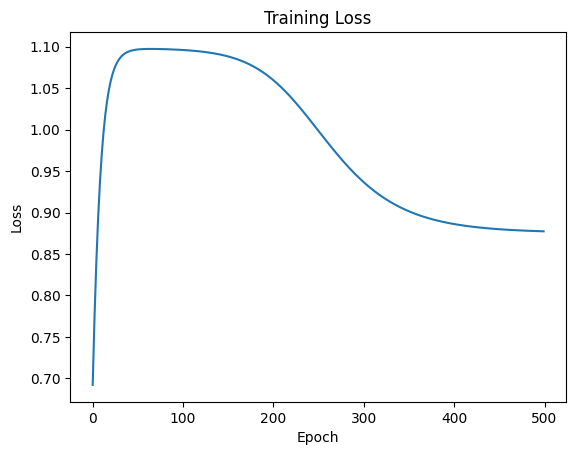

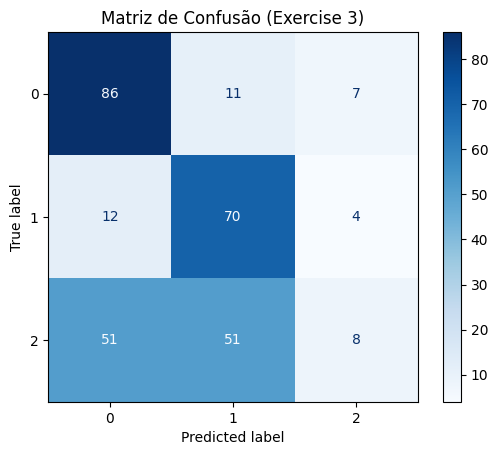

In [316]:
X0, _ = make_classification(
        n_samples=500, n_features=4, n_informative=4, n_redundant=0,
        n_classes=1, n_clusters_per_class=2, random_state=42
    )
y0 = np.zeros(len(X0))

X1, _ = make_classification(
    n_samples=500, n_features=4, n_informative=4, n_redundant=0,
    n_classes=1, n_clusters_per_class=3, random_state=42+1
)
y1 = np.ones(len(X1))

X2, _ = make_classification(
    n_samples=500, n_features=4, n_informative=4, n_redundant=0,
    n_classes=1, n_clusters_per_class=4, random_state=42
)
y2 = np.full(len(X2), 2)

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_oh = one_hot(y_train, 3)
y_test_oh = one_hot(y_test, 3)

W1, b1, W2, b2, losses = mlp(
    X_train, y_train_oh,
    epochs=500,
    neurons_per_layer=[4, 16, 3],
    lr=0.1,
    loss_type='cce'
)

y_pred = predict(X_test, W1, b1, W2, b2, loss_type='cce')
acc = np.mean(y_pred == y_test)
print("Test Accuracy:", acc)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão (Exercise 3)")
plt.show()